# Overview

Can a computer "learn" to classify artists by their paintings? 

ResNet50 is a good model for classifying ImageNet data. How about a set of 38 artists?

We use transfer learning to re-train a ResNet50 model to identify one of 38 artists who have more than ***200*** paintings in the dataset. 

This notebook is part of a project for CSC 480 taught by [Dr. Franz J. Kurfess](http://users.csc.calpoly.edu/~fkurfess/) at Cal Poly

A web application is [in development](https://github.com/SomethingAboutImages/WebImageClassifier) to make use of the model that this notebook outputs. 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# %matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info

import gc # garbage collection

In [2]:
MY_SEED = 42 # 480 could work too
seed(MY_SEED)
np.random.seed(MY_SEED)
tensorflow.random.set_seed(MY_SEED)

print(sys_info())
# get module information
# %pip freeze > frozen-requirements.txt
# append system information to file
# with open("frozen-requirements.txt", "a") as file:
#     file.write(sys_info())

{'commit_hash': '37242ba43',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython',
 'ipython_version': '8.12.0',
 'os_name': 'posix',
 'platform': 'Linux-5.15.0-1063-azure-x86_64-with-glibc2.17',
 'sys_executable': '/anaconda/envs/py38_default/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.8.16 (default, Mar  2 2023, 03:21:46) \n[GCC 11.2.0]'}


In [ ]:
# %pip install -r "C:\Users\jesus\Desktop\Projecte\XNAPproject-grup07\our_code\frozen-requirements.txt" 

# %pip install -r '/home/xnmaster/Project/XNAPproject-grup07/our_code/frozen-requirements.txt'

In [8]:
# %pip install tensorflow[and-cuda]

In [2]:
# %pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
ERROR: Could not find a version that satisfies the requirement torch==1.12.1+cu113 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0)
ERROR: No matching distribution found for torch==1.12.1+cu113
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
print(torch.cuda.is_available()) # Ha de ser True

True


In [4]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 248518112391005690
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15247015936
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15023911663256879483
physical_device_desc: "device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


In [5]:
# https://stackoverflow.com/questions/25705773/image-cropping-tool-python
# because painting images are hella big
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [22]:
# %pip install Pillow --upgrade

In [44]:
# globals

DATA_DIR = '/home/xnmaster/Project/input' # r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input" 
TRAIN_1_DIR =  '/home/xnmaster/Project/input/train_10_artists' # r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input\train_1\train_1"

# DATA_DIR = r"/Users/jesus/Desktop/Projecte/" 
# TRAIN_1_DIR =  r"/Users/jesus/Desktop/Projecte/train_1" 

# TRAIN_2_DIR = '../input/painters-train-part-1/train_2/train_2/'
# TRAIN_3_DIR = '../input/painters-train-part-1/train_3/train_3/'

# TRAIN_4_DIR = '../input/painters-train-part-2/train_4/train_4/'
# TRAIN_5_DIR = '../input/painters-train-part-2/train_5/train_5/'
# TRAIN_6_DIR = '../input/painters-train-part-2/train_6/train_6/'

# TRAIN_7_DIR = '../input/painters-train-part-3/train_7/train_7/'
# TRAIN_8_DIR = '../input/painters-train-part-3/train_8/train_8/'
# TRAIN_9_DIR = '../input/painters-train-part-3/train_9/train_9/'

# TRAIN_DIRS = [TRAIN_1_DIR, TRAIN_2_DIR, TRAIN_3_DIR,
#              TRAIN_4_DIR, TRAIN_5_DIR, TRAIN_6_DIR,
#              TRAIN_7_DIR, TRAIN_8_DIR, TRAIN_9_DIR]

TRAIN_DIRS = [TRAIN_1_DIR]

# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
TEST_DIR = '/home/xnmaster/Project/input/test'  # r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input\test\test" 

Execute in local and virtual
(no cal cada vegada, només una vegada pq elimina les fotos que no són vàlides)

In [7]:
from PIL import Image
import os

# Function to check if a file is an image
def is_image(file_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    return any(file_path.lower().endswith(ext) for ext in image_extensions)

# Function to check if an image file is valid
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except Exception as e:
        print(f"Invalid image: {file_path} - {e}")
        # Remove the file if it's invalid
        os.remove(file_path)
        print(f"Removed file: {file_path}")
        return False

# Validate images in a directory
def validate_images(directory):
    print(f"Validating images in directory: {directory}")
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and is_image(file_path):
            if is_valid_image(file_path):
                print(f"Valid image: {file_path}")

# Validate training and testing directories
def validate_directories(*directories):
    for directory in directories:
        if not os.path.exists(directory):
            raise ValueError(f"Directory does not exist: {directory}")
        if not os.path.isdir(directory):
            raise ValueError(f"Not a directory: {directory}")

# Validate training and testing directories
validate_directories(DATA_DIR, TEST_DIR)
for train_dir in TRAIN_DIRS:
    validate_directories(train_dir)

# Validate images in training and testing directories
validate_images(DATA_DIR)
validate_images(TEST_DIR)
for train_dir in TRAIN_DIRS:
    validate_images(train_dir)


Validating images in directory: /home/xnmaster/Project/input
Validating images in directory: /home/xnmaster/Project/input/test
Valid image: /home/xnmaster/Project/input/test/24002.jpg
Valid image: /home/xnmaster/Project/input/test/73811.jpg
Valid image: /home/xnmaster/Project/input/test/67468.jpg
Valid image: /home/xnmaster/Project/input/test/1174.jpg
Valid image: /home/xnmaster/Project/input/test/25904.jpg
Valid image: /home/xnmaster/Project/input/test/39368.jpg
Valid image: /home/xnmaster/Project/input/test/25547.jpg
Valid image: /home/xnmaster/Project/input/test/69260.jpg
Valid image: /home/xnmaster/Project/input/test/64880.jpg
Valid image: /home/xnmaster/Project/input/test/1206.jpg
Valid image: /home/xnmaster/Project/input/test/20127.jpg
Valid image: /home/xnmaster/Project/input/test/29973.jpg
Valid image: /home/xnmaster/Project/input/test/22060.jpg
Valid image: /home/xnmaster/Project/input/test/62874.jpg
Valid image: /home/xnmaster/Project/input/test/33899.jpg
Valid image: /home/x

In [45]:
# Get the list of files in the folder
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_train = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_train)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_test = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_test)


Number of files in the folder TRAIN_1_DIR: 2600
Number of files in the folder TEST_DIR: 7025


After augmentation

In [47]:
# Get the list of files in the folder
TRAIN_1_DIR = "/home/xnmaster/Project/input/train_10_artists_flip"
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_train = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_train)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_test = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_test)


Number of files in the folder TRAIN_1_DIR: 10400
Number of files in the folder TEST_DIR: 7025


In [24]:
# df = pd.read_csv(DATA_DIR + 'all_data_info.csv/all_data_info.csv') 
df = pd.read_csv(DATA_DIR + '/all_data_info/all_data_info.csv') # r'\all_data_info\all_data_info.csv'
print("df.shape", df.shape)

df.shape (103250, 12)


In [13]:
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [25]:
# quick fix for corrupted files
list_of_corrupted = ['3917.jpg','18649.jpg','20153.jpg','41945.jpg',
'79499.jpg','91033.jpg','92899.jpg','95347.jpg',
'100532.jpg','101947.jpg']
# display the corrupted rows of dataset for context
corrupt_df = df[df["new_filename"].isin(list_of_corrupted) == True]
print(corrupt_df.head(len(list_of_corrupted)))

# completely get rid of them
df = df[df["new_filename"].isin(list_of_corrupted) == False]

# try to see if they are still there
print(df[df["new_filename"].isin(list_of_corrupted) == True])

print("df.shape", df.shape)

                             artist    date              genre  pixelsx  \
185                  Giorgio Vasari    1534           portrait   3512.0   
731                       Juan Gris    1918          cityscape   2844.0   
994                       Juan Gris    1917         still life   3918.0   
1084   John Roddam Spencer Stanhope    1860     genre painting   4249.0   
1105                 Henri Rousseau    1908          cityscape   3403.0   
9984   John Roddam Spencer Stanhope     NaN  symbolic painting   1309.0   
19876              Georgia O'Keeffe  1915.0           abstract   1400.0   
28748                    Franz Marc    1913    animal painting    951.0   
46256           Esaias van de Velde    1622          landscape    942.0   
98236                 George Inness     NaN  literary painting    376.0   

       pixelsy  size_bytes     source                         style  \
185     4850.0  10360549.0    wikiart  Mannerism (Late Renaissance)   
731     3882.0   5393504.0    wi

Keep the works of artists who have a representation above 50%

In [29]:
# Step 1: Count occurrences of each artist
artist_counts = df['artist'].value_counts()

In [ ]:
for artist in artist_counts:
    print(artist)

Above 499 artistic works

In [30]:
artists_above_499 = artist_counts[artist_counts >= 499].index
filtered_df = df[df['artist'].isin(artists_above_499)]

Above 199 artistic works

In [28]:
artists_above_99 = artist_counts[artist_counts >= 99].index
filtered_df = df[df['artist'].isin(artists_above_99)]

Keep files in directories of the filtered artists
(no executar si ja s'ha executat una vegada, si ja es té la carpeta nova)

In [29]:
import shutil


# Define the input folder
#input_folder = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input"

input_folder = r"/Users/jesus/Desktop/Projecte"

# Define the output folder where you want to move the files
#output_folder = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input_new"

output_folder = r"/Users/jesus/Desktop/Projecte/input_new"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate over the rows in the filtered DataFrame
for index, row in filtered_df.iterrows():
    # Extract the new_filename from the DataFrame
    new_filename = row['new_filename']
    
    # Determine the subdirectory of the file (train_1 or test)
    source_subdirectory = "train_1" 
    # source_subdirectory = "test"

    # Search for the file in the input folder and its subdirectories
    for root, dirs, files in os.walk(os.path.join(input_folder, source_subdirectory)):
        if new_filename in files:
            # Get the full path of the file
            file_path = os.path.join(root, new_filename)
            
            # Determine the destination subdirectory
            destination_subdirectory = os.path.join(output_folder, source_subdirectory)
            
            # Create the destination subdirectory if it doesn't exist
            os.makedirs(destination_subdirectory, exist_ok=True)
            
            # Define the destination path where you want to move the file
            destination_path = os.path.join(destination_subdirectory, new_filename)
            
            # Move the file to the output folder
            shutil.move(file_path, destination_path)


In [30]:
# Define the input folder
#input_folder = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input"

input_folder = r"/Users/jesus/Desktop/Projecte"

# Define the output folder where you want to move the files
#output_folder = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input_new"

output_folder = r"/Users/jesus/Desktop/Projecte/input_new"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate over the rows in the filtered DataFrame
for index, row in filtered_df.iterrows():
    # Extract the new_filename from the DataFrame
    new_filename = row['new_filename']
    
    # Determine the subdirectory of the file (train_1 or test)
    # source_subdirectory = "train_1" 
    source_subdirectory = "test"

    # Search for the file in the input folder and its subdirectories
    for root, dirs, files in os.walk(os.path.join(input_folder, source_subdirectory)):
        if new_filename in files:
            # Get the full path of the file
            file_path = os.path.join(root, new_filename)
            
            # Determine the destination subdirectory
            destination_subdirectory = os.path.join(output_folder, source_subdirectory)
            
            # Create the destination subdirectory if it doesn't exist
            os.makedirs(destination_subdirectory, exist_ok=True)
            
            # Define the destination path where you want to move the file
            destination_path = os.path.join(destination_subdirectory, new_filename)
            
            # Move the file to the output folder
            shutil.move(file_path, destination_path)


In [10]:
# globals

DATA_DIR = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input_new" # '/home/xnmaster/Project/input'
TRAIN_1_DIR =  r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input_new\train_1" # '/home/xnmaster/Project/input/train_1'

TRAIN_DIRS = [TRAIN_1_DIR]
TEST_DIR = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input_new\test" # '/home/xnmaster/Project/input/test'

# ATA_DIR = r"/Users/jesus/Desktop/Projecte/input_new" 
# TRAIN_1_DIR =  r"/Users/jesus/Desktop/Projecte/input_new/train_1" 

# TRAIN_DIRS = [TRAIN_1_DIR]
# TEST_DIR = r"/Users/jesus/Desktop/Projecte/input_new/test" 

In [11]:
# Get the list of files in the folder
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_folder = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_folder)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_folder = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_folder)


Number of files in the folder TRAIN_1_DIR: 631
Number of files in the folder TEST_DIR: 399


Artists

In [30]:
train_df = df[df["in_train"] == True]
test_df = df[df['in_train'] == False]
train_df = df[['artist', 'new_filename']]
test_df = test_df[['artist', 'new_filename']]

print("test_df.shape", test_df.shape)
print("train_df.shape", train_df.shape)

# artists = {} # holds artist hash & the count
# for a in filtered_df['artist']:
#     if (a not in artists):
#         artists[a] = 1
#     else:
#         artists[a] += 1

# training_set_artists = []
# for a,count in artists.items():
#     if(int(count) >= 200): # it takes no more than 200 artists
#         training_set_artists.append(a)

# print("number of artists",len(training_set_artists))

# print("\nlist of artists...\n", training_set_artists)


test_df.shape (23814, 2)
train_df.shape (103240, 2)


In [27]:
artists = {'Ivan Aivazovsky': 500,
 'John Singer Sargent': 500,
 'Pierre-Auguste Renoir': 500,
 'Marc Chagall': 500,
 'Pablo Picasso': 500,
 'Zdislav Beksinski': 500,
 'Ivan Shishkin': 500,
 'Gustave Dore': 500,
 'Ilya Repin': 500,
 'Giovanni Battista Piranesi': 500}

In [28]:
training_set_artists = ['Ivan Aivazovsky',
 'John Singer Sargent',
 'Pierre-Auguste Renoir',
 'Marc Chagall',
 'Pablo Picasso',
 'Zdislav Beksinski',
 'Ivan Shishkin',
 'Gustave Dore',
 'Ilya Repin',
 'Giovanni Battista Piranesi']

In [29]:
t_df = train_df[train_df["artist"].isin(training_set_artists)]

t_df.head(5)

,artist,new_filename
14,Ivan Aivazovsky,99442.jpg
28,Gustave Dore,7486.jpg
29,Gustave Dore,35766.jpg
34,Gustave Dore,31977.jpg
82,Ivan Aivazovsky,81750.jpg


In [31]:
t1_df = t_df[t_df['new_filename'].str.startswith('1')]

t2_df = t_df[t_df['new_filename'].str.startswith('2')]

t3_df = t_df[t_df['new_filename'].str.startswith('3')]

t4_df = t_df[t_df['new_filename'].str.startswith('4')]

t5_df = t_df[t_df['new_filename'].str.startswith('5')]

t6_df = t_df[t_df['new_filename'].str.startswith('6')]

t7_df = t_df[t_df['new_filename'].str.startswith('7')]

t8_df = t_df[t_df['new_filename'].str.startswith('8')]

t9_df = t_df[t_df['new_filename'].str.startswith('9')]

all_train_dfs = [t1_df, t2_df, t3_df,
                t4_df, t5_df, t6_df,
                t7_df, t8_df, t9_df]

t9_df.head(5)

,artist,new_filename
14,Ivan Aivazovsky,99442.jpg
591,Giovanni Battista Piranesi,96147.jpg
634,Giovanni Battista Piranesi,94943.jpg
681,Giovanni Battista Piranesi,97939.jpg
748,Giovanni Battista Piranesi,98150.jpg


In [32]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# specify the model that classifies 38 artists 🎨 🖌

## wandb
Execute following lines if we use wandb

In [ ]:
# %pip install wandb -qU

In [36]:
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint
wandb.login()
# 0927244f833ccea1b247099feaaaf54084a5c30c

In [28]:
# import random
# Start a run, tracking hyperparameters
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7"
    # track hyperparameters and run metadata with wandb.config
    # config={
    #     "layer_1": 512,
    #     "activation_1": "softmax", # relu
    #     "dropout": random.uniform(0.01, 0.80),
    #     "layer_2": 10,
    #     # "activation_2": "softmax",
    #     "optimizer": "adam",
    #     "loss": "sparse_categorical_crossentropy",
    #     "metric": "accuracy",
    #     "epoch": 8,
    #     "batch_size": 256,
    # },
)

# [optional] use wandb.config as your config
# config = run.config


## without wandb

In [33]:
len(training_set_artists)

10

In [ ]:
# augmentation_layers = [
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
# ]


# def data_augmentation(x):
#     for layer in augmentation_layers:
#         x = layer(x)
#     return x


# train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [37]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam = Sequential()

model_adam.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam.add(Dense(
  num_classes,
  activation='softmax'
))

model_adam.layers[0].trainable = False

In [35]:
model_sgd = Sequential()

model_sgd.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_sgd.add(Dense(
  num_classes,
  activation='softmax'
))

model_sgd.layers[0].trainable = False

In [38]:
model_RMS = Sequential()
model_RMS.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_RMS.add(Dense(
  num_classes,
  activation='softmax'
))

model_RMS.layers[0].trainable = False

# Compile Model

## Adam

In [39]:
model_adam.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

**Observation**
para un problema de clasificación binaria, a menudo se utiliza la 'entropía cruzada binaria', mientras que la 'entropía cruzada categórica' se utiliza para la clasificación de clases múltiples.
https://www.sourcetrail.com/es/pit%C3%B3n/keras/modelo-compilar-keras/

## SGD

In [40]:
model_sgd.compile(
  optimizer='sgd', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

## RMSprop

In [41]:
model_RMS.compile(optimizer ='RMSprop', 
              loss ='categorical_crossentropy', 
              metrics =['accuracy'])

# Setup the image data generator for each training directory 

In [48]:
print("Files in train:", num_files_in_train)
print("Files in test:", num_files_in_test)

Files in train: 10400
Files in test: 7025


In [49]:
def batch_size(num_fitxers, max_batch_size=64):
    for size in range(max_batch_size, 0, -1):
        if num_fitxers % size == 0:
            return size
    return 1 

BATCH_SIZE = batch_size(num_files_in_train)
TEST_BATCH_SIZE = batch_size(num_files_in_test)

print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"TEST_BATCH_SIZE: {TEST_BATCH_SIZE}")


BATCH_SIZE: 52
TEST_BATCH_SIZE: 25


In [50]:
# model globals
IMAGE_SIZE = 224
VAL_SPLIT = 0.25

In [51]:
def setup_generators(
    val_split, train_dataframe, train_dir,
    img_size, batch_size, my_seed, list_of_classes,
    test_dataframe, test_dir, test_batch_size
):
    print("-"*20)
    if not preprocess_input:
          raise Exception("please do import call 'from tensorflow.python.keras.applications.resnet50 import preprocess_input'")

    # setup resnet50 preprocessing 
    data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=val_split)

    print(len(train_dataframe), "images in", train_dir, "and validation_split =", val_split)
    print("\ntraining set ImageDataGenerator")
    train_gen = data_gen.flow_from_dataframe(
        dataframe=train_dataframe.reset_index(), # call reset_index() so keras can start with index 0
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        target_size=(img_size, img_size),
        subset="training",
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        class_mode='categorical',
        classes=list_of_classes
    )

    print("\nvalidation set ImageDataGenerator")
    valid_gen = data_gen.flow_from_dataframe(
        dataframe=train_dataframe.reset_index(), # call reset_index() so keras can start with index 0
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        subset="validation",
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        target_size=(img_size,img_size),
        class_mode='categorical',
        classes=list_of_classes
    )

    test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    print("\ntest set ImageDataGenerator")
    test_gen = test_data_gen.flow_from_dataframe(
        dataframe=test_dataframe.reset_index(), # call reset_index() so keras can start with index 0
        directory=test_dir,
        x_col='new_filename',
        y_col=None,
        has_ext=True,
        batch_size=test_batch_size,
        seed=my_seed,
        shuffle=False, # dont shuffle test directory
        class_mode=None,
        target_size=(img_size,img_size)
    )

    return (train_gen, valid_gen, test_gen)

print("defined setup_generators()")

defined setup_generators()


In [52]:
# delete some unused dataframes to free some RAM for training
del df
del t_df
del t1_df
del t2_df
del t3_df
del t4_df
del t5_df
del t6_df
del t7_df
del t8_df
del t9_df
gc.collect()

47859

In [53]:
train_gens = [None]*len(TRAIN_DIRS)
valid_gens = [None]*len(TRAIN_DIRS)
test_gen  = None # only 1 test_gen
i = 0
for i in range(0, len(TRAIN_DIRS)):
    train_gens[i], valid_gens[i], test_gen = setup_generators(
        train_dataframe=all_train_dfs[i], train_dir=TRAIN_DIRS[i],
        val_split=VAL_SPLIT, img_size=IMAGE_SIZE, batch_size=BATCH_SIZE, my_seed=MY_SEED, 
        list_of_classes=training_set_artists, test_dataframe=test_df, 
        test_dir=TEST_DIR, test_batch_size=TEST_BATCH_SIZE
    )
    i += 1

--------------------
706 images in /home/xnmaster/Project/input/train_10_artists and validation_split = 0.25

training set ImageDataGenerator
Found 394 validated image filenames belonging to 10 classes.

validation set ImageDataGenerator
Found 131 validated image filenames belonging to 10 classes.


/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 181 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 181 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(



test set ImageDataGenerator
Found 7025 validated image filenames.


/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 16789 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


# TRAINING TIME!  🎉 🎊 🎁

In [54]:
MAX_EPOCHS = 5 * len(train_gens) # should be a multiple of 9 because need evenly train each train_dir
DIR_EPOCHS = 1 # fit each train_dir at least this many times before overfitting

In [55]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## wandb

In [37]:
%%wandb # per veure-ho en directe
hist_adam = model_adam.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)


Epoch 1/5


c:\Users\Mercè\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0674 - loss: 4.5659

wandb: ERROR Unable to log learning rate.


5/5 ━━━━━━━━━━━━━━━━━━━━ 60s 9s/step - accuracy: 0.0734 - loss: 4.4390 - val_accuracy: 0.0573 - val_loss: 4.5979
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 10s/step - accuracy: 0.2676 - loss: 2.3320 - val_accuracy: 0.1529 - val_loss: 4.1692
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 106s 20s/step - accuracy: 0.4851 - loss: 1.5466 - val_accuracy: 0.1847 - val_loss: 3.0541
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 116s 21s/step - accuracy: 0.6812 - loss: 1.0419 - val_accuracy: 0.2166 - val_loss: 2.6339
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 113s 20s/step - accuracy: 0.7743 - loss: 0.7903 - val_accuracy: 0.2357 - val_loss: 2.9640


In [38]:
run.finish()

epoch/accuracy,▁▃▅▇█
epoch/epoch,▁▃▅▆█
epoch/loss,█▄▃▂▁
epoch/val_accuracy,▁▅▆▇█
epoch/val_loss,█▆▂▁▂
epoch/accuracy,0.78903
epoch/epoch,4
epoch/loss,0.77206
epoch/val_accuracy,0.23567
epoch/val_loss,2.96397


## manual

In [56]:
histories_adam = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam.append(
            model_adam.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 32s 2s/step - loss: 2.2697 - accuracy: 0.2018 - val_loss: 5.3946 - val_accuracy: 0.1442
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 1.3018 - accuracy: 0.5877 - val_loss: 6.3523 - val_accuracy: 0.2885
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.8456 - accuracy: 0.7310 - val_loss: 6.4476 - val_accuracy: 0.3462
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.6497 - accuracy: 0.8070 - val_loss: 6.3411 - val_accuracy: 0.3558
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.4860 - accuracy: 0.8713 - val_loss: 6.5877 - val_accuracy: 0.3654


In [57]:
histories_sgd = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_sgd.append(
            model_sgd.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 20s 3s/step - loss: 2.3205 - accuracy: 0.2251 - val_loss: 3.2048 - val_accuracy: 0.2404
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 14s 2s/step - loss: 1.3750 - accuracy: 0.5322 - val_loss: 3.2416 - val_accuracy: 0.2788
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 1.0510 - accuracy: 0.6871 - val_loss: 3.3881 - val_accuracy: 0.3173
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.8841 - accuracy: 0.7281 - val_loss: 3.4871 - val_accuracy: 0.3365
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.7446 - accuracy: 0.7836 - val_loss: 3.5372 - val_accuracy: 0.3269


In [58]:
histories_RMS = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_RMS.append(
            model_RMS.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 19s 3s/step - loss: 2.0293 - accuracy: 0.3129 - val_loss: 4.1664 - val_accuracy: 0.3654
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 1.0891 - accuracy: 0.6462 - val_loss: 4.6713 - val_accuracy: 0.3269
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.8115 - accuracy: 0.7281 - val_loss: 4.3325 - val_accuracy: 0.4135
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.6265 - accuracy: 0.8187 - val_loss: 4.8583 - val_accuracy: 0.3654
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 16s 2s/step - loss: 0.4779 - accuracy: 0.8764 - val_loss: 5.2872 - val_accuracy: 0.3365


# Evaluate the model 🧐 🤔

In [59]:
accuracies_adam = []
val_accuracies_adam = []
losses_adam = []
val_losses_adam = []
for hist in histories_adam:
    if hist:
        accuracies_adam += hist.history['accuracy']
        val_accuracies_adam += hist.history['val_accuracy']
        losses_adam += hist.history['loss']
        val_losses_adam += hist.history['val_loss']

In [60]:
accuracies_sgd = []
val_accuracies_sgd = []
losses_sgd = []
val_losses_sgd = []
for hist in histories_sgd:
    if hist:
        accuracies_sgd += hist.history['accuracy']
        val_accuracies_sgd += hist.history['val_accuracy']
        losses_sgd += hist.history['loss']
        val_losses_sgd += hist.history['val_loss']

In [61]:
accuracies_RMS = []
val_accuracies_RMS = []
losses_RMS = []
val_losses_RMS = []
for hist in histories_RMS:
    if hist:
        accuracies_RMS += hist.history['accuracy']
        val_accuracies_RMS += hist.history['val_accuracy']
        losses_RMS += hist.history['loss']
        val_losses_RMS += hist.history['val_loss']

## Plots
### Accuracies

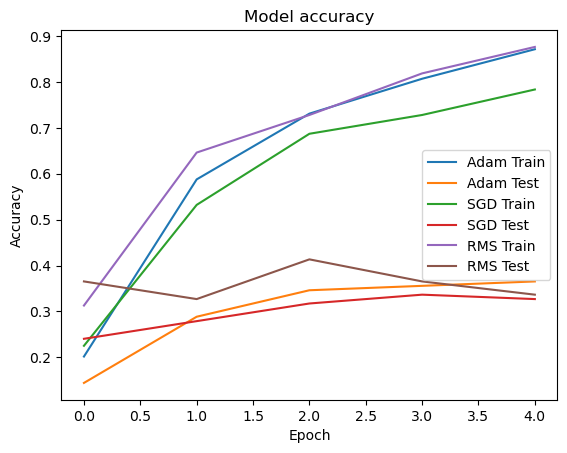

In [62]:
# Plot training & validation accuracy values
plt.plot(accuracies_adam, label = "Adam Train")
plt.plot(val_accuracies_adam, label = "Adam Test")

plt.plot(accuracies_sgd, label = "SGD Train")
plt.plot(val_accuracies_sgd, label = "SGD Test")

plt.plot(accuracies_RMS, label = "RMS Train")
plt.plot(val_accuracies_RMS, label = "RMS Test")

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [63]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_acc_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_accuracy_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

### Loss values

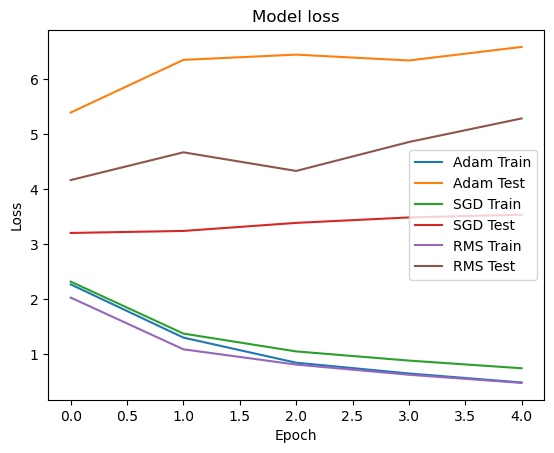

In [64]:
# Plot training & validation loss values
plt.plot(losses_adam, label = "Adam Train")
plt.plot(val_losses_adam, label = "Adam Test")

plt.plot(losses_sgd, label = "SGD Train")
plt.plot(val_losses_sgd, label = "SGD Test")

plt.plot(losses_RMS, label = "RMS Train")
plt.plot(val_losses_RMS, label = "RMS Test")

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [65]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_loss_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_loss_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

# Predict the output 🔮 🎩

In [66]:
PRED_STEPS = len(test_gen) # 100 # default would have been len(test_gen)
PRED_STEPS

281

In [67]:
# Need to reset the test_gen before calling predict_generator
# This is important because forgetting to reset the test_generator results in outputs with a weird order.
test_gen.reset()
pred_adam = model_adam.predict(test_gen)

281/281 [==============================] - 206s 696ms/step


In [68]:
print(len(pred_adam),"\n",pred_adam)

7025 
 [[2.19789706e-03 2.36001983e-03 1.28215656e-03 ... 3.86833970e-04
  1.66458695e-03 1.37416052e-07]
 [5.04414842e-04 2.42737820e-03 3.97137424e-04 ... 2.58866989e-04
  8.29809438e-03 4.88020957e-09]
 [2.13244278e-02 1.37367994e-02 1.17972605e-01 ... 5.11079049e-03
  1.12372175e-01 3.78950119e-07]
 ...
 [3.92121561e-02 1.02607729e-02 2.00224994e-03 ... 2.14079246e-05
  9.58305411e-03 7.45740181e-08]
 [4.36110310e-02 1.05515003e-01 2.70839091e-02 ... 2.61315377e-03
  7.80279785e-02 6.84378892e-06]
 [1.46417157e-03 2.14268804e-01 1.61025852e-01 ... 2.34607633e-05
  1.00389598e-02 5.91813262e-07]]


In [69]:
predicted_class_indices_adam = np.argmax(pred_adam,axis=1)

In [70]:
def retrieve_results(predicted_class_indices, train_gens):
    print(len(predicted_class_indices),"\n",predicted_class_indices)
    print("it has values ranging from ",min(predicted_class_indices),"...to...",max(predicted_class_indices))
    labels = (train_gens[0].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    print("*"*20+"\nclass_indices\n"+"*"*20+"\n",train_gens[0].class_indices,"\n")
    print("*"*20+"\nlabels\n"+"*"*20+"\n",labels,"\n")
    print("*"*20+"\npredictions has", len(predictions),"values that look like","'"+str(predictions[0])+"' which is the first prediction and corresponds to this index of the classes:",train_gens[0].class_indices[predictions[0]])
    # Save the results to a CSV file.
    filenames=test_gen.filenames[:len(predictions)] # because "ValueError: arrays must all be same length"

    real_artists = []
    for f in filenames:
        real = test_df[test_df['new_filename'] == f].artist.to_numpy()[0]
        real_artists.append(real)

    results=pd.DataFrame({"Filename":filenames,
                        "Predictions":predictions,
                        "Real Values":real_artists})
    results.to_csv("results.csv",index=False)

    return results

## Adam

In [71]:
results_adam = retrieve_results(predicted_class_indices_adam, train_gens)

7025 
 [4 3 5 ... 3 3 3]
it has values ranging from  0 ...to... 8
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 7025 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


In [72]:
results_adam.head()

,Filename,Predictions,Real Values
0,836.jpg,Pablo Picasso,kiri nichol
1,49823.jpg,Marc Chagall,Hiroshige
2,32996.jpg,Zdislav Beksinski,Paul Serusier
3,77203.jpg,Marc Chagall,Hiroshige
4,75956.jpg,Ivan Shishkin,Jan Matejko


In [73]:
len(training_set_artists)

10

In [74]:
print(training_set_artists)

['Ivan Aivazovsky', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Marc Chagall', 'Pablo Picasso', 'Zdislav Beksinski', 'Ivan Shishkin', 'Gustave Dore', 'Ilya Repin', 'Giovanni Battista Piranesi']


In [75]:
def testing_new_images(results, training_set_artists):  
    count = 0
    match = 0
    unexpected_count = 0
    unexpected_match = 0
    match_both_expected_unexpected = 0

    for p, r in zip(results['Predictions'], results['Real Values']):
        if r in training_set_artists:
            count += 1
            if p == r:
                match += 1
        else:
            unexpected_count += 1
            if p == r:
                unexpected_match += 1

    print("test accuracy on new images for TRAINED artists")
    acc = match/count
    print(match,"/",count,"=","{:.4f}".format(acc))

    print("test accuracy on new images for UNEXPECTED artists")
    print("unexpected_match", unexpected_match)
    print("unexpected_count", unexpected_count)
    
    if unexpected_count != 0:
        u_acc = unexpected_match/unexpected_count
        print(unexpected_match,"/",unexpected_count,"=","{:.4f}".format(u_acc))

    print("test accuracy on new images")
    total_match = match+unexpected_match
    total_count = count+unexpected_count
    total_acc = (total_match)/(total_count)
    print(total_match,"/",total_count,"=","{:.4f}".format(total_acc))

In [76]:
testing_new_images(results_adam, training_set_artists)

test accuracy on new images for TRAINED artists
209 / 335 = 0.6239
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
209 / 7025 = 0.0298


## SGD

In [77]:
test_gen.reset()
pred_sgd = model_sgd.predict(test_gen, verbose=1, steps=PRED_STEPS)
print(len(pred_sgd),"\n",pred_sgd)

281/281 [==============================] - 194s 656ms/step
7025 
 [[0.1060534  0.00189086 0.01220842 ... 0.00208685 0.00471185 0.00602741]
 [0.02323929 0.02384404 0.00310966 ... 0.00185493 0.2636736  0.00103247]
 [0.00253916 0.0170283  0.09650473 ... 0.0080207  0.51358426 0.00110644]
 ...
 [0.07315973 0.08979933 0.01469805 ... 0.00150872 0.26204443 0.00153859]
 [0.04898017 0.1605065  0.08826549 ... 0.0273473  0.17661346 0.00704253]
 [0.01900322 0.25924274 0.03096018 ... 0.0060804  0.16836058 0.00859417]]


In [78]:
predicted_class_indices_sgd = np.argmax(pred_sgd,axis=1)

In [79]:
results_sgd = retrieve_results(predicted_class_indices_sgd, train_gens)
results_sgd.head()

7025 
 [4 3 8 ... 5 4 1]
it has values ranging from  0 ...to... 8
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 7025 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


,Filename,Predictions,Real Values
0,836.jpg,Pablo Picasso,kiri nichol
1,49823.jpg,Marc Chagall,Hiroshige
2,32996.jpg,Ilya Repin,Paul Serusier
3,77203.jpg,Pablo Picasso,Hiroshige
4,75956.jpg,Ivan Shishkin,Jan Matejko


In [80]:
print(len(training_set_artists))
print(training_set_artists)

10
['Ivan Aivazovsky', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Marc Chagall', 'Pablo Picasso', 'Zdislav Beksinski', 'Ivan Shishkin', 'Gustave Dore', 'Ilya Repin', 'Giovanni Battista Piranesi']


In [81]:
testing_new_images(results_sgd, training_set_artists)

test accuracy on new images for TRAINED artists
178 / 335 = 0.5313
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
178 / 7025 = 0.0253


## RMSprop

In [82]:
test_gen.reset()
pred_RMS = model_RMS.predict(test_gen, verbose=1, steps=PRED_STEPS)
print(len(pred_RMS),"\n",pred_RMS)

281/281 [==============================] - 194s 656ms/step
7025 
 [[6.7375705e-02 6.8349735e-04 3.3846821e-03 ... 2.6587269e-03
  2.8653780e-02 1.2685920e-04]
 [1.8300090e-03 4.6913731e-03 9.7720954e-04 ... 6.1489135e-04
  3.2399211e-02 4.4184339e-06]
 [2.2840879e-03 3.0175978e-03 4.3142624e-02 ... 6.2376796e-04
  8.2352263e-01 7.1090208e-06]
 ...
 [2.4751291e-01 1.0128704e-02 1.6597796e-03 ... 9.7641452e-05
  9.9283069e-02 2.0270307e-04]
 [2.0617327e-02 1.3766646e-02 8.2365923e-02 ... 5.1532527e-03
  4.5121798e-01 1.5816136e-04]
 [4.7153337e-03 1.0640197e-02 2.1993956e-01 ... 4.5724091e-04
  2.2106953e-01 6.6542467e-05]]


In [83]:
predicted_class_indices_RMS = np.argmax(pred_RMS,axis=1)

In [84]:
results_RMS = retrieve_results(predicted_class_indices_RMS, train_gens)
results_RMS.head()

7025 
 [4 3 8 ... 3 8 3]
it has values ranging from  0 ...to... 8
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 7025 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


,Filename,Predictions,Real Values
0,836.jpg,Pablo Picasso,kiri nichol
1,49823.jpg,Marc Chagall,Hiroshige
2,32996.jpg,Ilya Repin,Paul Serusier
3,77203.jpg,Pablo Picasso,Hiroshige
4,75956.jpg,Ivan Shishkin,Jan Matejko


In [85]:
print(len(training_set_artists))
print(training_set_artists)

10
['Ivan Aivazovsky', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Marc Chagall', 'Pablo Picasso', 'Zdislav Beksinski', 'Ivan Shishkin', 'Gustave Dore', 'Ilya Repin', 'Giovanni Battista Piranesi']


In [86]:
testing_new_images(results_RMS, training_set_artists)

test accuracy on new images for TRAINED artists
189 / 335 = 0.5642
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
189 / 7025 = 0.0269


# Improving our best model
- Adam: test accuracy on new images for TRAINED artists 209 / 335 = 0.6239
- SGD: test accuracy on new images for TRAINED artists 178 / 335 = 0.5313
- RMSProp: test accuracy on new images for TRAINED artists 189 / 335 = 0.5642


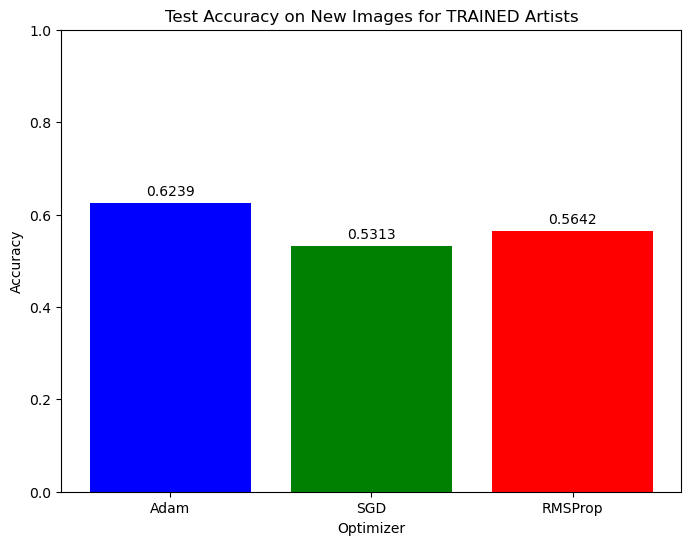

In [87]:
import matplotlib.pyplot as plt

# Dades d'accuràcia per als diferents optimitzadors
optimizers = ['Adam', 'SGD', 'RMSProp']
accuracies = [0.6239, 0.5313, 0.5642]

# Crear el gràfic de barres
plt.figure(figsize=(8, 6))
plt.bar(optimizers, accuracies, color=['blue', 'green', 'red'])

# Afegir títol i etiquetes
plt.title('Test Accuracy on New Images for TRAINED Artists')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')

# Mostrar els valors d'accuràcia sobre les barres
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy:.4f}', ha='center', va='bottom')

# Mostrar el gràfic
plt.ylim(0, 1)  # Ajustar el límit de l'eix Y per visualitzar millor les barres
plt.show()


## Finetuning
We finetune Adam

In [ ]:
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint
wandb.login()
# 0927244f833ccea1b247099feaaaf54084a5c30c

# Start a run, tracking hyperparameters
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7"
)

In [88]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam = Sequential()

model_adam.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam.add(Dense(
  num_classes,
  activation='softmax'
))

layer0 = model_adam.layers[0]
layer1 = model_adam.layers[1]

In [ ]:
MAX_EPOCHS = 5 * len(train_gens) # should be a multiple of 9 because need evenly train each train_dir
DIR_EPOCHS = 1 #


%%wandb # per veure-ho en directe
hist_adam = model_adam.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)


In [ ]:
run.finish()

### Freezing all the model

In [89]:
layer0.trainable = False
layer1.trainable = False

In [91]:
model_adam.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

In [92]:
# manual
histories_adam_frozen = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam_frozen.append(
            model_adam.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 19s 2s/step - loss: 3.1271 - accuracy: 0.0497 - val_loss: 2.4236 - val_accuracy: 0.0865
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 3.1126 - accuracy: 0.0585 - val_loss: 2.4460 - val_accuracy: 0.0865
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 14s 2s/step - loss: 3.1243 - accuracy: 0.0556 - val_loss: 2.5057 - val_accuracy: 0.0962
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 16s 2s/step - loss: 3.1022 - accuracy: 0.0497 - val_loss: 2.5226 - val_accuracy: 0.0769
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 3.1418 - accuracy: 0.0522 - val_loss: 2.4666 - val_accuracy: 0.0865


In [93]:
accuracies_adam_frozen = []
val_accuracies_adam_frozen = []
losses_adam_frozen = []
val_losses_adam_frozen = []
for hist in histories_adam_frozen:
    if hist:
        accuracies_adam_frozen += hist.history['accuracy']
        val_accuracies_adam_frozen += hist.history['val_accuracy']
        losses_adam_frozen += hist.history['loss']
        val_losses_adam_frozen += hist.history['val_loss']

### Unfreezing layer1

In [94]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam = Sequential()

model_adam.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam.add(Dense(
  num_classes,
  activation='softmax'
))

layer0 = model_adam.layers[0]
layer1 = model_adam.layers[1]

In [95]:
layer1.trainable = True

In [97]:
model_adam.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

In [98]:
# manual
histories_adam_unfrozen1 = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam_unfrozen1.append(
            model_adam.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 49s 2s/step - loss: 1.6539 - accuracy: 0.4883 - val_loss: 111.8660 - val_accuracy: 0.1154
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.9621 - accuracy: 0.7456 - val_loss: 1932.8289 - val_accuracy: 0.1250
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.6401 - accuracy: 0.8538 - val_loss: 2012.3904 - val_accuracy: 0.0385
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.7885 - accuracy: 0.7982 - val_loss: 16352.1006 - val_accuracy: 0.1346
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.4680 - accuracy: 0.8684 - val_loss: 61595.7578 - val_accuracy: 0.1731


In [99]:
accuracies_adam_unfrozen1  = []
val_accuracies_adam_unfrozen1  = []
losses_adam_unfrozen1 = []
val_losses_adam_unfrozen1 = []
for hist in histories_adam_unfrozen1:
    if hist:
        accuracies_adam_unfrozen1 += hist.history['accuracy']
        val_accuracies_adam_unfrozen1 += hist.history['val_accuracy']
        losses_adam_unfrozen1 += hist.history['loss']
        val_losses_adam_unfrozen1 += hist.history['val_loss']

### Unfreezing layer1 and layer0

In [100]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam = Sequential()

model_adam.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam.add(Dense(
  num_classes,
  activation='softmax'
))

layer0 = model_adam.layers[0]
layer1 = model_adam.layers[1]

In [101]:
layer0.trainable = True

In [102]:
model_adam.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

In [103]:
# manual
histories_adam_unfrozen2 = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam_unfrozen2.append(
            model_adam.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 47s 2s/step - loss: 1.6962 - accuracy: 0.4942 - val_loss: 1394.5631 - val_accuracy: 0.0577
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.8346 - accuracy: 0.7339 - val_loss: 492.2099 - val_accuracy: 0.0288
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.7245 - accuracy: 0.8158 - val_loss: 609.2695 - val_accuracy: 0.1058
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.8375 - accuracy: 0.7778 - val_loss: 8467.7725 - val_accuracy: 0.0673
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.5357 - accuracy: 0.8567 - val_loss: 3787.8933 - val_accuracy: 0.0096


In [104]:
accuracies_adam_unfrozen2  = []
val_accuracies_adam_unfrozen2  = []
losses_adam_unfrozen2 = []
val_losses_adam_unfrozen2 = []
for hist in histories_adam_unfrozen2:
    if hist:
        accuracies_adam_unfrozen2 += hist.history['accuracy']
        val_accuracies_adam_unfrozen2 += hist.history['val_accuracy']
        losses_adam_unfrozen2 += hist.history['loss']
        val_losses_adam_unfrozen2 += hist.history['val_loss']


### Comparision finetunings

#### Accuracies

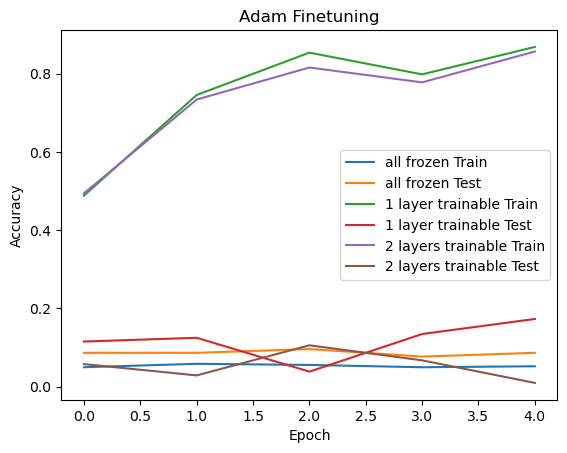

In [105]:
# Plot training & validation accuracy values
plt.plot(accuracies_adam_frozen, label = "all frozen Train")
plt.plot(val_accuracies_adam_frozen, label = "all frozen Test")

plt.plot(accuracies_adam_unfrozen1, label = "1 layer trainable Train")
plt.plot(val_accuracies_adam_unfrozen1, label = "1 layer trainable Test")

plt.plot(accuracies_adam_unfrozen2, label = "2 layers trainable Train")
plt.plot(val_accuracies_adam_unfrozen2, label = "2 layers trainable Test")

plt.title('Adam Finetuning')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [106]:
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_accuracy_finetuning_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

#### Losses

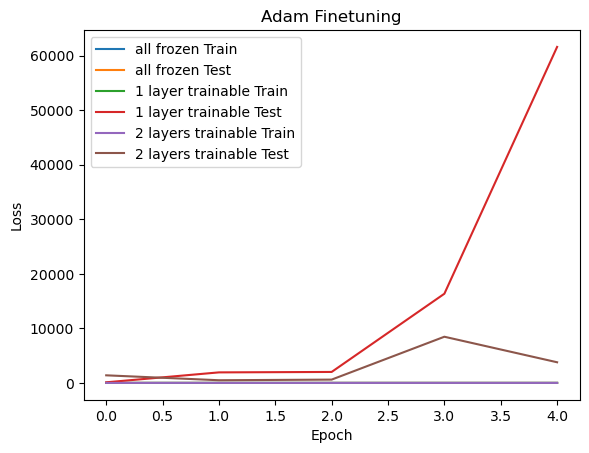

In [107]:
# Plot training & validation accuracy values
plt.plot(losses_adam_frozen, label = "all frozen Train")
plt.plot(val_losses_adam_frozen, label = "all frozen Test")

plt.plot(losses_adam_unfrozen1, label = "1 layer trainable Train")
plt.plot(val_losses_adam_unfrozen1, label = "1 layer trainable Test")

plt.plot(losses_adam_unfrozen2, label = "2 layers trainable Train")
plt.plot(val_losses_adam_unfrozen2, label = "2 layers trainable Test")

plt.title('Adam Finetuning')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [108]:
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_loss_finetuning_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

# Ideas
- Having a the prediction dataset: Filename, Predictions, Real Values. We can construct a composition of the predictions.
- We can now predict artist and another caracteristic (like stryle).

## Mosaics

In [109]:
def calculate_position(current_index, total_images_per_row, image_width, image_height, margin):
    row = current_index // total_images_per_row
    col = current_index % total_images_per_row
    x = col * (image_width + margin)
    y = row * (image_height + margin)
    return (x, y)


In [114]:
# Load the dataset
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10

# Create compositions
# Create compositions
for predicted_artist, group in grouped_data:
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_images = len(group)
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.load_default()
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        # Open the image file
        image = Image.open(TEST_DIR + "/" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    # composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
    composition.save('/home/xnmaster/Project/XNAPproject-grup07/compostions/predictions_10400_images/composition_{}.png'.format(predicted_artist))